In [79]:
import Parity_Data_Generator
import numpy as np
from pyESN import ESN
import matplotlib.pyplot as plt
import time

rng = np.random.RandomState(42)

In [80]:
N = 4000   # number of datapoints (20000 is fine),  apparently even 7k
n = 3       # n-parity
timescale=50

start_time = time.time()
# produce Data
bits, parity, target = Parity_Data_Generator.generateParityData(N, n, timescale=timescale, randomstate=rng)

# Divide in training and test data
traintest_cutoff = int(np.ceil(0.7 * len(bits)))
train_bits, test_bits = bits[:traintest_cutoff], bits[traintest_cutoff:]
train_parity, test_parity = parity[:traintest_cutoff], parity[traintest_cutoff:]
# train_targets, test_targets = target[:traintest_cutoff], target[traintest_cutoff:]

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.010502099990844727 seconds ---


harvesting states...
fitting...


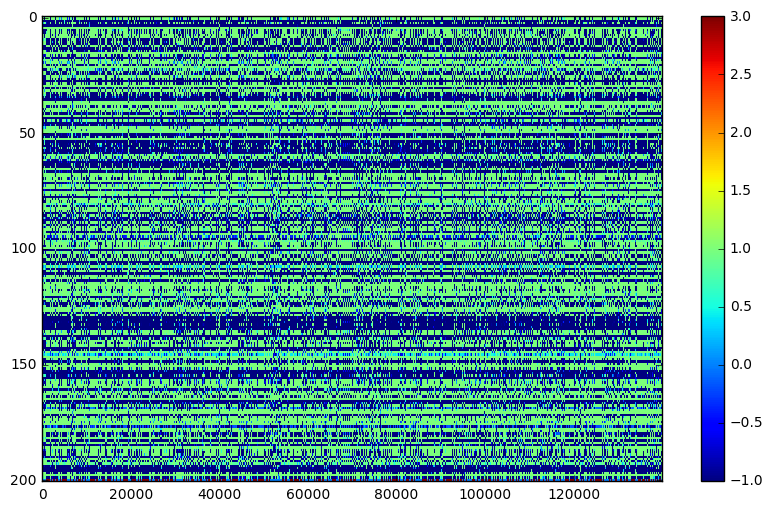

training error:
0.45072197491
Testing error
0.455777902525


In [81]:
nParityESN = ESN(n_inputs=1,
                          n_outputs=1,
                          n_reservoir=200,  # from 200 onwards test error decreases significantly
                          spectral_radius=0.8,  # high spectral rad is better (high fluctuations 0->1->0)
                          leak_rate= 0.1,   # adjust leak_rate
                          sparsity=0.95,     # 0.95
                          noise=0.01,      # 0.01
                          input_shift=0,    # 0
                          input_scaling=3,  # 3 seems to be fine. Maybe use lower
                          teacher_forcing=False, # No need for teacher forcing because we have no pattern
                          teacher_scaling=1.12,
                          teacher_shift=-0.7,
                          random_state=rng,
                          silent=False)
nParityESN.fit(train_bits, train_parity, inspect=True)
pred_test = nParityESN.predict(test_bits)

    #### not rounding
predictedParity = pred_test # not rounding
    #### Rounding
#     better_pred_test = []           # Maybe don't round and return "true" results from pred_test
#     for x in pred_test:
#         better_pred_test.append(0 if x < 0.5 else 1)
#     predictedParity = np.array(better_pred_test).reshape(-1,1)
    
print("Testing error")
test_error = np.sqrt(np.mean((predictedParity - test_parity) ** 2))
print(test_error)
## Lowest test-error: 0.16 (s-rad 0.95, l-rate 0.1, sparsity 0.5, noise 0.001, input-shift -0.5)

60000


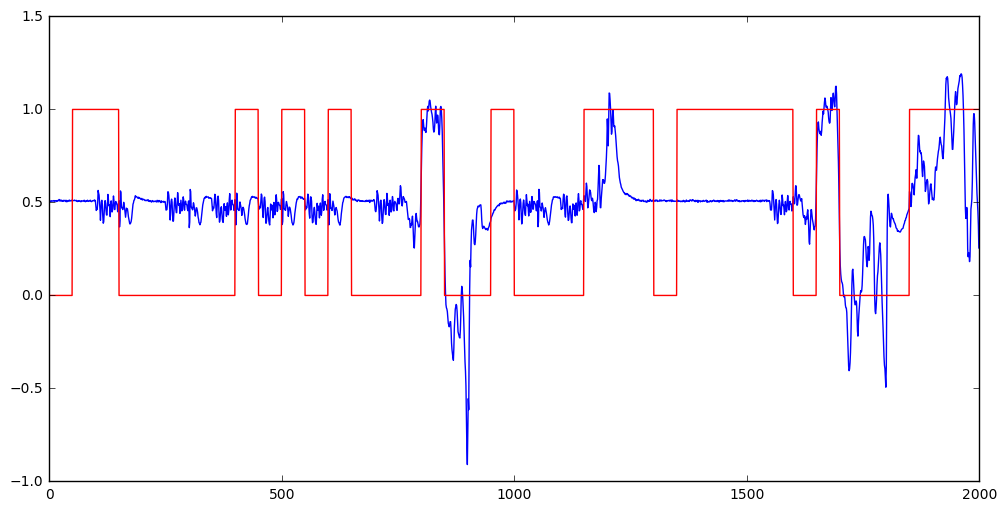

In [82]:
plt.figure(figsize=(12,6))
plt.subplot(111)
print(len(predictedParity))
# plt.plot(predictedParity[66600:66800])
plt.plot(predictedParity[5000:7000],"b")
plt.plot(test_parity[5000:7000], "r")
plt.show()

In [83]:
##### Create Training Data for fastESN with output from slowESN
start_time = time.time()

new_rng = np.random.RandomState(1337)
new_N, new_n = 3000, 3
new_bits, new_parity, new_target = Parity_Data_Generator.generateParityData(new_N, new_n,timescale=timescale, randomstate=new_rng)

# Divide in training and test data
traintest_cutoff = int(np.ceil(0.7 * len(new_bits)))
new_train_bits, new_test_bits = new_bits[:traintest_cutoff], new_bits[traintest_cutoff:]
# new_train_parity, new_test_parity = new_parity[:traintest_cutoff], new_parity[traintest_cutoff:]
new_train_targets, new_test_targets = new_target[:traintest_cutoff], new_target[traintest_cutoff:]

train_predicted_parity = nParityESN.predict(new_train_bits)
test_predicted_parity = nParityESN.predict(new_test_bits)

print("--- %s seconds ---" % (time.time() - start_time))

--- 6.4410786628723145 seconds ---


harvesting states...
fitting...


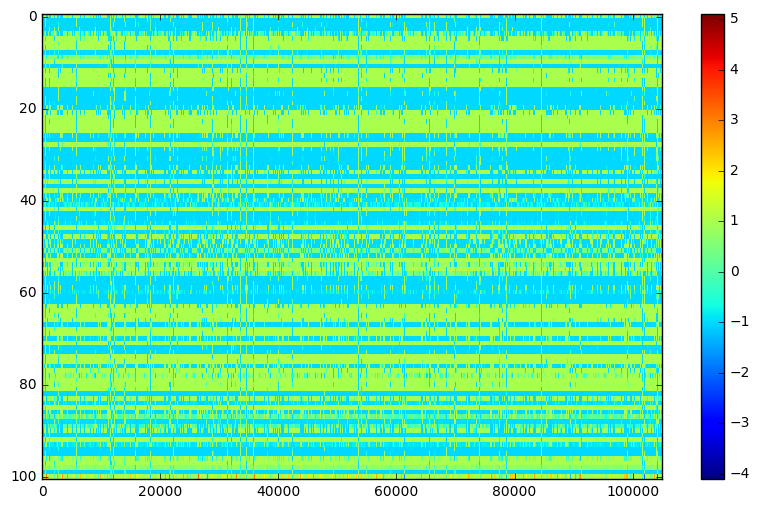

training error:
0.410378301339
Testing error
0.410805769904


In [84]:
outputESN = ESN(n_inputs=1,
                              n_outputs=1,
                              n_reservoir=100,  
                              spectral_radius=0.8,  # 0.95
                              leak_rate= 0.1,   # 0.6
                              sparsity=0.95,     # 0.95
                              noise=0.01,
                              input_shift=-0.5,  # 0
                              input_scaling=3,  # 3 seems to be fine. Maybe use lower
                              teacher_forcing=False,
                              teacher_scaling=1.12,
                              teacher_shift=-0.4,
#                               out_activation=np.tanh,
#                               inverse_out_activation=np.arctanh,
                              random_state=new_rng,
                              silent=False)
outputESN.fit(train_predicted_parity, new_train_targets,inspect=True)
pred_targets = outputESN.predict(test_predicted_parity) # what was actually predicted from slowESN

print("Testing error")
test_error = np.sqrt(np.mean((pred_targets - new_test_targets) ** 2))
print(test_error)

45000


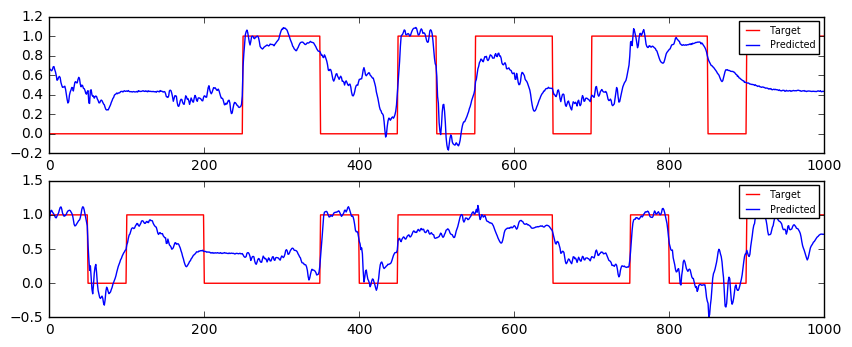

In [85]:
# Show Plots
# print(test_targets)
print(len(new_test_targets))
plt.figure(figsize=(10,6))

# plt.subplot(311)
# plt.plot(new_test_parity[1400:1800])

plt.subplot(312)
plt.plot(new_test_targets[1400:2400], "r", label="Target")
plt.plot(pred_targets[1400:2400], "b", label="Predicted")
plt.legend(fontsize="x-small")

plt.subplot(313)
plt.plot(new_test_targets[8400:9400], "r", label="Target")
plt.plot(pred_targets[8400:9400], "b", label="Predicted")
plt.legend(fontsize="x-small")
plt.show()

In [86]:
l_rate = np.linspace(0.1, 1, num=10)
print (l_rate)

[ 0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1. ]
